## Step 2: Noise Models and Fidelity Degradation


In [15]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error


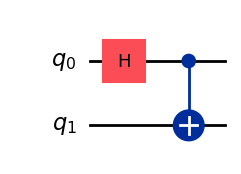

In [16]:
def create_bell_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    return qc

bell = create_bell_circuit()
bell.draw("mpl")


(A) Depolarizing Noise

In [17]:
from qiskit_aer.noise import depolarizing_error, NoiseModel

def depolarizing_noise_model(p1, p2):
    """
    p1: 1-qubit gate error probability
    p2: 2-qubit gate error probability
    """
    noise_model = NoiseModel()

    error_1q = depolarizing_error(p1, 1)
    error_2q = depolarizing_error(p2, 2)

    noise_model.add_all_qubit_quantum_error(error_1q, ['h'])
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

    return noise_model



With probability p, the qubit becomes completely random.

Models control errors, cross-talk, calibration drift.

(B) Amplitude Damping (Energy Loss)

In [18]:
from qiskit_aer.noise import amplitude_damping_error

def amplitude_damping_noise_model(gamma):
    noise_model = NoiseModel()

    error_1q = amplitude_damping_error(gamma)

    noise_model.add_all_qubit_quantum_error(error_1q, ['h'])
    noise_model.add_all_qubit_quantum_error(error_1q.tensor(error_1q), ['cx'])

    return noise_model



Models T₁ relaxation

Excited state decays to ground state

In [19]:
def simulate_noisy_state(noise_model):
    sim = AerSimulator(noise_model=noise_model)
    qc = create_bell_circuit()
    qc.save_statevector()
    result = sim.run(qc).result()
    return Statevector(result.get_statevector())


Fidelity vs Noise Strength
(A) Target (Ideal) State

In [20]:
ideal_state = Statevector.from_label("00").evolve(create_bell_circuit())


(B) Sweep Noise Strength

In [21]:
noise_strengths = np.linspace(0, 0.1, 12)

fidelity_depol = []
fidelity_amp = []

for p in noise_strengths:
    noisy_depol = simulate_noisy_state(
        depolarizing_noise_model(p1=p, p2=2*p)
    )
    fidelity_depol.append(state_fidelity(noisy_depol, ideal_state))

    noisy_amp = simulate_noisy_state(
        amplitude_damping_noise_model(gamma=p)
    )
    fidelity_amp.append(state_fidelity(noisy_amp, ideal_state))


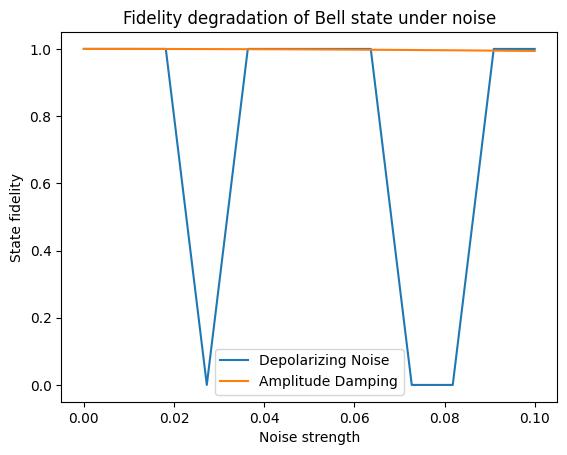

In [22]:
plt.figure()
plt.plot(noise_strengths, fidelity_depol, label="Depolarizing Noise")
plt.plot(noise_strengths, fidelity_amp, label="Amplitude Damping")
plt.xlabel("Noise strength")
plt.ylabel("State fidelity")
plt.title("Fidelity degradation of Bell state under noise")
plt.legend()
plt.show()
